**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

# *Ensemble and balancing approaches for an imbalanced multiclass classification problem* 

## Abstract

Imbalanced datasets pose some difficulties in classification tasks. This project aimed to assess the effectiveness of several different ensemble methods and balancing of the dataset, as proposed in literature. The best performing classifier was found to be a One vs. Rest classifier with an XGBoosted estimator applied to an imbalanced dataset, though many avenues were left to be explored. Among the methods that failed to perform well were PCA+kNN, synthetic oversampling, Bagging Classifiers, Random Forests, Neural Networks and balanced ensembles. Rather surprisingly, synthetic balancing and balanced ensembles performed much worse than classifiers on imbalanced sets. We suggest that this is due to the fact that it is favorable for a classifier to predict the majority class when the dataset is imbalanced. This is reflected in the conflicting metrics of accuracy and logloss. When the dataset is balanced synthetically, the classifiers lose "the majority edge" and end up more confused. Finally, we propose future directions for analysing this specific problem.

## 1. Introduction

Ensemble methods use the variety of available classifiers, combining the various classifiers rather than relying on a single
classifier. By ensembling classifiers, also called base learners, it is possible to obtain ensembles that are more
accurate than single classifiers. Actually, the base learners of an ensemble are called weak learners, as they can provide
slighly better results than guessing as individuals. By building an ensemble these weak learners can be boosted to become
strong learners, with accurate results. These ensembled classifiers can then be used to classify new examples, or predict the
current data with more accuracy. Naturally, it follows that the necessary requirements for an ensemble of classifiers is
that they are more accurate and diverse than any of its individual base learners. [1, 2]

For an ensemble of classifiers to be diverse the ensemble needs to produce errors that are uncorrelated with each other,
i.e. they cannot produce the same errors. Consider three classifiers h1(x), h2(x) and h3(x): based on the requirements
of an ensemble, the classifiers have to be diverse. This means that if h1(x) is wrong, h2(x) and h3(x) could be correct
and the classification of x would be correct by the majority of the classifiers. In a case where the ensemble is not diverse,
h1(x) = wrong would mean that the the two other classifiers would produce similar results with h1(x), classifying x
incorrectly. [1]

When evaluating imbalanced datasets, the importance of ensemble methods is heightened. Imbalanced datasets possess
various classes of data, some which are under-represented. Often, we are most interested in the minority classes as they
often possess the most valuable data or cost more to analyse. [3] This is where ensemble methods have an important role.
To correctly analyse the scarce, minority datasets, multiclassification, such as ensemble classification can be used to
analyse the scarce data with more accuracy compared to a single classifier. However, it is important to notice that the performance of ensembled methods can decrease radically if the dataset in
consideration is too scarce in data. This particular problem can be tackled with oversampling, for example. Oversampling is
a method of creating a super-set of the original minority class, either by replicating old values or creating new data 
points. [3]

According to Dietterich (2000), without having a sufficient amount of data (of a class, in this case) the learning 
algorithm can form multiple hypotheses, but these hypotheses would end up having same accuracies. However, by ensembling
these hypotheses together, it is possible to average these hypotheses to produce more accurate results. However, as 
mentioned earlier, ensemble methods have reduced accuracy as the sample size becomes smaller. [1]

In regards to the project at hand, we will implement several ensemble methods in order to improve the accuracy of the
imbalanced dataset. Our learning goal is to understand how ensembled methods work with real-life data, instead of the
theoretical concept that predicts increased accuracy for data analysis using ensembled methods. It contrast, it could 
also be that the minority classes are too scarce in data, resulting in decreased accuracy for ensembled methods. In 
real-world situations the data is often imbalanced and needs processing before it can be analysed in any level. 
As such, it is important to understand the value of different techniques, and most of all, their weaknesses so that 
the processing and analysis of future datasets can be performed more effectively.

This data analysis project consists of a data processing section, where the data is cleaned to ensure more accurate
classifications. In the third section we use a variety of classifiers to classificate the data, ensemble these classifiers and then aim to balance the data by both over- and undersampling. Both sampling methods are used to reduce the bias of the data in order for the classifiers to process the data more accurately. In results section, we summarise the results and discuss the meaning of the values in the discussion section.

## 2. Data analysis

In [2]:
# Import libraries
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib

# Config matplotlib
%matplotlib inline

In [9]:
# Data has the following shape:
# ID | Rhythm patterns |   Chroma   |   MFCCs
# 1         2 - 169       170 - 217   218 - 265
#
#
#

# Load training data
df_data = pd.read_csv('train_data.csv', header=None)
df_labels = pd.read_csv('train_labels.csv', header=None)
data = pd.concat([df_labels, df_data], axis='columns', ignore_index=True)

It is important to understand the data one is trying to classify. Here want to find clues of broken and/or highly collinear feature columns so they may be dropped for a more accurate classification.

In [10]:
# Let's get to know our features
rhythm = data.iloc[:, 1:169].copy()
chroma = data.iloc[:, 169:217].copy()
mfcc = data.iloc[:, 217:265].copy()

# Summaries
rhythm_summary = rhythm.describe()
chroma_summary = chroma.describe()
mfcc_summary = mfcc.describe()

print('Rhythm summarized:\n', rhythm_summary)
print('Chroma summarized:\n', chroma_summary)
print('MFCC summarized:\n', mfcc_summary)

Rhythm summarized:
                1            2            3            4            5    \
count  4363.000000  4363.000000  4363.000000  4363.000000  4363.000000   
mean   3097.683714  4390.947408  3987.672465  4004.861996  3086.664978   
std    1309.219331  1457.625815  1228.185868  1242.336635  1031.020501   
min       1.240000     3.565000    73.644000   147.370000    58.027000   
25%    2200.900000  3386.150000  3128.650000  3173.200000  2373.000000   
50%    3114.600000  4376.800000  3988.500000  3976.300000  3041.300000   
75%    3949.150000  5391.900000  4814.950000  4795.300000  3741.400000   
max    9172.400000  9062.500000  8318.100000  9342.200000  8275.700000   

               6            7            8            9            10   \
count  4363.000000  4363.000000  4363.000000  4363.000000  4363.000000   
mean   3329.815872  3043.628357  3034.574066  2671.463266  2440.464016   
std    1124.845689  1097.705493  1121.064034  1017.781965   970.028384   
min     136.67000

Immediately we see that there are something wrong with Chroma and MFCC ranges of features. We might benefit from inspecting their Pearson correlation matrices.

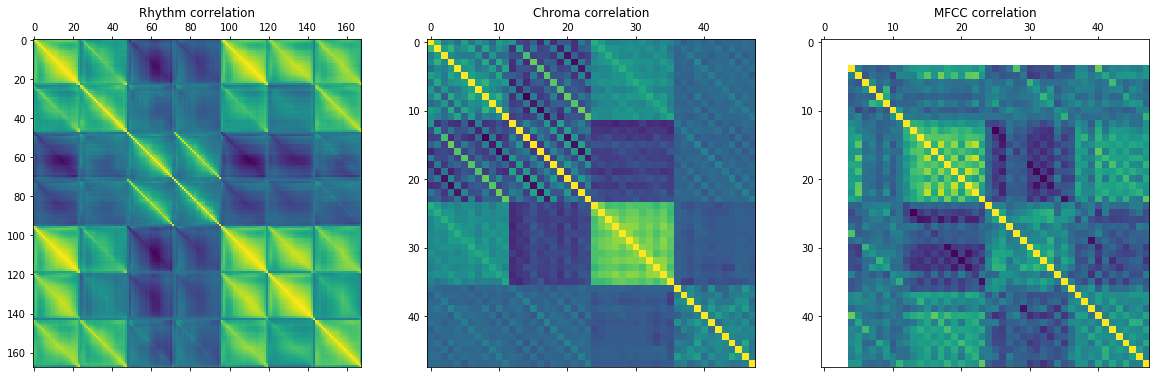

In [4]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))
ax1.matshow(rhythm.corr())
ax1.set_title('Rhythm correlation')

ax2.matshow(chroma.corr())
ax2.set_title('Chroma correlation')

ax3.matshow(mfcc.corr())
ax3.set_title('MFCC correlation')

plt.show()

It appears that the first 4 feature columns in the MFCC range are identical and these could interfere with analysis. Equally, peeking into the high correlation range inside Chroma statistics, we see that the last 24 features of chroma variate hardly any between rows. We can probably safely remove these from the analysis.

Next we want to see if our dataset is balanced between classes.

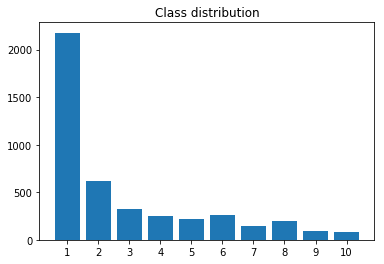

In [5]:
# Training label distribution
instances, counts = np.unique(df_labels, return_counts=True)
frequencies = np.array((instances, counts)).T

plt.bar(instances, counts)
plt.title('Class distribution')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.show()

Our dataset is greatly imbalanced. Below we consider many ways to combat class imbalance in a classification problem.

## 3. Methods and experiments

### 3.1. Data preprocessing

In data preprocessing the bad quality features were first dropped. The plan was to use heavy spot-checking to find the best approaches for these particular data. To avoid any unnecessary skew in the results (some algorithms are more sensitive to outliers and scaling than others), outliers were weeded out and finally the data was scaled using a Yeo-Johnson transformation. This has the effect of stabilizing variance and minimizing skewness. The function for data preprocessing was also equipped with the capability of serving feature class and feature statistic specific datasets to test ensemble learners on subsets of features.

In [4]:
# Three ways to inspect features:
# 1. Cleaned
# 2. Cleaned and divided into classes (rhythm, chroma, mfcc)
# 3. Cleaned and divided into statistics (subclasses of classes)
# Build a function that returns a dataset as required
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, PowerTransformer  # For reviewers: PowerTransformer requires sklearn 0.20

def create_dataset(partitioning=None):
    # Read datasets
    df_data = pd.read_csv('train_data.csv', header=None)
    df_labels = pd.read_csv('train_labels.csv', header=None)
    data = pd.concat([df_labels, df_data], axis='columns', ignore_index=True)

    # Rhythm
    rhythm = data.iloc[:, 1:169].copy()

    # Chroma remove last 24 features
    chroma = data.iloc[:, 169:217].copy()
    chroma_cleaned = data.iloc[:, 169:193]

    # MFCCs remove first 4 features
    mfcc = data.iloc[:, 217:265].copy()
    mfcc_cleaned = data.iloc[:, 221:265].copy()

    cleaned_x = pd.concat([rhythm, chroma_cleaned, mfcc_cleaned],
                          axis='columns',
                          ignore_index=True)

    # Outlier detection and removal
    threshold = 3
    for col in range(cleaned_x.shape[1]):
        mean = np.mean(cleaned_x.iloc[:, col])
        z = np.abs(stats.zscore(cleaned_x.iloc[:, col]))
        rows = np.where(z > threshold)
        for row in rows:
            cleaned_x.at[row, col] = mean

    # Scaling
    #scaler = MinMaxScaler(), use if you want to use a different scaling, PowerTransformer was found to be the best though.
    scaler = PowerTransformer() # Defaults to Yeo-Johnson, because our features have negative values
    scaled_data = scaler.fit_transform(cleaned_x)
    scaled_df = pd.DataFrame(scaled_data)  # Back into a DataFrame for pandas operations

    if partitioning == 'classes':

        rhythm_set = pd.concat([df_labels, scaled_df.iloc[:, 0:168]], axis='columns', ignore_index=True)
        chroma_set = pd.concat([df_labels, scaled_df.iloc[:, 168:192]], axis='columns', ignore_index=True)
        mfcc_set = pd.concat([df_labels, scaled_df.iloc[:, 192:236]], axis='columns', ignore_index=True)

        return [rhythm_set, chroma_set, mfcc_set]

    elif partitioning == 'statistics':

        # Rhythm set includes 7 statistics
        set1 = pd.concat([df_labels, scaled_df.iloc[:, 0:24]], axis='columns', ignore_index=True)
        set2 = pd.concat([df_labels, scaled_df.iloc[:, 24:48]], axis='columns', ignore_index=True)
        set3 = pd.concat([df_labels, scaled_df.iloc[:, 48:72]], axis='columns', ignore_index=True)
        set4 = pd.concat([df_labels, scaled_df.iloc[:, 72:96]], axis='columns', ignore_index=True)
        set5 = pd.concat([df_labels, scaled_df.iloc[:, 96:120]], axis='columns', ignore_index=True)
        set6 = pd.concat([df_labels, scaled_df.iloc[:, 120:144]], axis='columns', ignore_index=True)
        set7 = pd.concat([df_labels, scaled_df.iloc[:, 144:168]], axis='columns', ignore_index=True)

        # Chroma set includes 4 statistics but 2 are cleaned away
        set8 = pd.concat([df_labels, scaled_df.iloc[:, 168:180]], axis='columns', ignore_index=True)
        set9 = pd.concat([df_labels, scaled_df.iloc[:, 180:192]], axis='columns', ignore_index=True)

        # MFCC set includes 4 statistics. Last feature set is shorter due to cleaning
        set10 = pd.concat([df_labels, scaled_df.iloc[:, 192:200]], axis='columns', ignore_index=True)
        set11 = pd.concat([df_labels, scaled_df.iloc[:, 200:212]], axis='columns', ignore_index=True)
        set12 = pd.concat([df_labels, scaled_df.iloc[:, 212:224]], axis='columns', ignore_index=True)
        set13 = pd.concat([df_labels, scaled_df.iloc[:, 224:236]], axis='columns', ignore_index=True)

        return [set1, set2, set3, set4, set5,
                set6, set7, set8, set9, set10,
                set11, set12, set13]
    else:
        return pd.concat([df_labels, scaled_df], axis='columns', ignore_index=True)

To find the best possible approach, a wide net for spot-checking was cast. The performance of the following classifiers were tested:
-  Support vector classifier
-  Decision tree classifier
-  Naive Bayes classifier
-  Random forest classifier
-  PCA + kNN classifier
-  A Neural Network
-  Logistic Regression classifier
-  XGBoost

Each classifier was tested with a shallow search of their respective parameter spaces. Below we define functions used in spot-checking.

In [8]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV


def support_vector_classifier(x_train, y_train, x_test, y_test):
    kernel_params = ['linear', 'poly', 'rbf', 'sigmoid']

    current_best_score = 0
    current_best_svc = None
    for kernel in kernel_params:
        clf = SVC(kernel=kernel, gamma='auto', probability=True)
        svc_fit = clf.fit(x_train, y_train)
        svc_score = svc_fit.score(x_test, y_test)
        if svc_score > current_best_score:
            current_best_score = svc_score
            current_best_svc = svc_fit


    return current_best_svc, current_best_score

def decision_tree_classifier(x_train, y_train, x_test, y_test):
    criterion_params = ['gini', 'entropy']
    class_weight_params = [None, 'balanced']

    current_best_score = 0
    current_best_tree = None
    for criterion in criterion_params:
        for class_weight in class_weight_params:
            clf = tree.DecisionTreeClassifier(criterion=criterion, class_weight=class_weight)
            tree_fit = clf.fit(x_train, y_train)
            tree_score = tree_fit.score(x_test, y_test)
            if tree_score > current_best_score:
                current_best_score = tree_score
                current_best_tree = tree_fit

    return current_best_tree, current_best_score

def naive_bayes(x_train, y_train, x_test, y_test):
    prior_params = [None, [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]]  # Balanced and uniform

    current_best_score = 0
    current_best_bayes = None
    for prior in prior_params:
        clf = GaussianNB(priors=prior)
        bayesian_fit = clf.fit(x_train, y_train)
        bayesian_score = bayesian_fit.score(x_test, y_test)
        if bayesian_score > current_best_score:
            current_best_score = bayesian_score
            current_best_bayes = bayesian_fit

    return current_best_bayes, current_best_score

def random_forest(x_train, y_train, x_test, y_test):

    n_estimator_params = [100, 500]
    criterion_params = ['gini', 'entropy']
    warm_start_params = [False, True]

    learning_rate_params = [0.05, 0.1]

    current_best_score = 0
    current_best_forest = None
    for estimator in n_estimator_params:
        for criterion in criterion_params:
            for warm_start in warm_start_params:
                clf = ExtraTreesClassifier(n_jobs=-1,
                                           n_estimators=estimator,
                                           criterion=criterion,
                                           warm_start=warm_start)
                forest_fit = clf.fit(x_train, y_train)
                forest_score = forest_fit.score(x_test, y_test)
                if forest_score > current_best_score:
                    current_best_score = forest_score
                    current_best_forest = forest_fit

    for estimator in n_estimator_params:
        for criterion in criterion_params:
            for warm_start in warm_start_params:
                clf = RandomForestClassifier(n_jobs=-1,
                                             n_estimators=estimator,
                                             criterion=criterion,
                                             warm_start=warm_start)
                forest_fit = clf.fit(x_train, y_train)
                forest_score = forest_fit.score(x_test, y_test)
                if forest_score > current_best_score:
                    current_best_score = forest_score
                    current_best_forest = forest_fit

    for estimator in n_estimator_params:
        for warm_start in warm_start_params:
            for rate in learning_rate_params:
                clf = GradientBoostingClassifier(n_estimators=estimator,
                                                 warm_start=warm_start,
                                                 learning_rate=rate)
                forest_fit = clf.fit(x_train, y_train)
                forest_score = forest_fit.score(x_test, y_test)
                if forest_score > current_best_score:
                    current_best_score = forest_score
                    current_best_forest = forest_fit

    return current_best_forest, current_best_score

def knn_classifier(data, x_train, y_train, x_test, y_test, n_components=35):
    # Performs PCA
    pca = PCA(n_components=n_components).fit(data.drop(labels=0, axis='columns'))
    data_train_reduced = pca.transform(x_train)
    data_test_reduced = pca.transform(x_test)

    # knn
    neighbor_params = [4, 5, 6, 7, 8, 9, 10]
    weights_params = ['uniform', 'distance']

    current_best_score = 0
    current_best_knn = None
    for neighbors in neighbor_params:
        for weight in weights_params:
            knn_classifier = knn(n_jobs=-1, n_neighbors=neighbors, weights=weight)
            knn_fit = knn_classifier.fit(data_train_reduced, y_train)
            knn_score = knn_fit.score(data_test_reduced, y_test)
            if knn_score > current_best_score:
                current_best_score = knn_score
                current_best_knn = knn_fit

    return current_best_knn, current_best_score


def neural_network(x_train, y_train, x_test, y_test):
    hidden_layer_size_params = [10, 100]
    activation_params = ['identity', 'logistic', 'tanh', 'relu']
    warm_start_params = [False, True]

    current_best_score = 0
    current_best_nn = None
    for size in hidden_layer_size_params:
        for activation in activation_params:
            for warm_start in warm_start_params:
                clf = MLPClassifier(hidden_layer_sizes=(size,),
                                    activation=activation,
                                    warm_start=warm_start,
                                    max_iter=300)
                nn_fit = clf.fit(x_train, y_train)
                nn_score = nn_fit.score(x_test, y_test)
                if nn_score > current_best_score:
                    current_best_score = nn_score
                    current_best_nn = nn_fit

    return current_best_nn, current_best_score

def logreg(x_train, y_train, x_test, y_test):
    # We can perform cross-validation for logreg automatically using LogisticRegressionCV
    logregCV = LogisticRegressionCV(Cs=np.logspace(-4, 5, 10), max_iter=100, solver='lbfgs', 
                                    n_jobs=-1, refit=True, cv=5, scoring='accuracy')
    logreg_fit = logregCV.fit(x_train, y_train)
    logreg_score = logreg_fit.score(x_test, y_test)
    
    return logreg_fit, logreg_score

XGBoost can be optimized either by stepwise or complete grid search. For convenience (running this takes a considerable amount of time) we provide a stepwise version below.

In [7]:
from xgboost.sklearn import XGBClassifier  # This is the sklearn wrapper for xgboost
from sklearn.model_selection import GridSearchCV  # And this is why we need it

In [ ]:
# Test run 1: Baseline
xgb1 = XGBClassifier(learning_rate=0.1,
                     n_estimators=1000,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective='multi:softmax',
                     nthread=4,
                     scale_pos_weight=1,
                     num_class=10,
                     seed=27)

xgb1_fit = xgb1.fit(x_train, y_train)
xgb1_score = xgb1_fit.score(x_test, y_test)
print('xgb1 score: ', xgb1_score)

# Parameter search 1: Max depth and Minimum child weight
param_test1 = {'max_depth': range(3, 10, 2),
               'min_child_weight': range(1, 6, 2)}

gsearch1 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                                                min_child_weight=1, gamma=0, subsample=0.8, 
                                                colsample_bytree=0.8, objective='multi:softmax', num_class=10, 
                                                nthread=4, scale_pos_weight=1, seed=27),
                        param_grid=param_test1, scoring='accuracy', n_jobs=-1, iid=False, cv=5)

gsearch1.fit(x_train, y_train)
print(gsearch1.best_params_, gsearch1.best_score_) # Use these results to make a more accurate search in the next step

In [ ]:
# Parameter search 2: More accuracy
param_test2 = {'max_depth': [6, 7, 8],
               'min_child_weight': [4, 5, 6]}
gsearch2 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                                                min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                objective='multi:softmax', num_class=10, nthread=4, scale_pos_weight=1, seed=27),
                        param_grid=param_test2, scoring='accuracy', n_jobs=-1, iid=False, cv=5)

gsearch2.fit(x_train, y_train)
print(gsearch2.best_params_, gsearch2.best_score_) # Use these results to continue with other parameters

In [ ]:
# Parameter search 3: Gamma
param_test3 = {'gamma': [i/10.0 for i in range(0, 5)]}
gsearch3 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=7,
                                                min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                objective='multi:softmax', num_class=10, nthread=4, scale_pos_weight=1, seed=27),
                        param_grid=param_test3, scoring='accuracy', n_jobs=-1, iid=False, cv=5)

gsearch3.fit(x_train, y_train)
print(gsearch3.best_params_, gsearch3.best_score_) # Use this in the next parameter search

In [ ]:
# Parameter search 4: Subsample and Colsample
param_test4 = {'subsample': [i/10.0 for i in range(6, 10)],
               'colsample_bytree': [i/10.0 for i in range(6, 10)]}
gsearch4 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=7,
                                                min_child_weight=5, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                                objective='multi:softmax', num_class=10, nthread=4, scale_pos_weight=1, seed=27),
                        param_grid=param_test4, scoring='accuracy', n_jobs=-1, iid=False, cv=5)

gsearch4.fit(x_train, y_train)
print(gsearch4.best_params_, gsearch4.best_score_) # Use these results to make a more accurate search in the next step

In [ ]:
# Parameter search 5: More accuracy
param_test5 = {'subsample': [i/100.0 for i in range(65, 80, 5)],
               'colsample_bytree': [i/100.0 for i in range(55, 70, 5)]}
gsearch5 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=177, max_depth=7,
                                                min_child_weight=5, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                                objective='multi:softmax', num_class=10, nthread=4, scale_pos_weight=1, seed=27),
                        param_grid=param_test5, scoring='accuracy', n_jobs=-1, iid=False, cv=5)

gsearch5.fit(x_train, y_train)
print(gsearch5.best_params_, gsearch5.best_score_) # Use this in the next parameter search

In [ ]:
# Parameter search 6: Reg_alpha
param_test6 = {'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]}
gsearch6 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=177, max_depth=7,
                                                min_child_weight=5, gamma=0.1, subsample=0.65, colsample_bytree=0.6,
                                                objective='multi:softmax', num_class=10, nthread=4, scale_pos_weight=1, seed=27),
                        param_grid=param_test6, scoring='accuracy', n_jobs=-1, iid=False, cv=5)

gsearch6.fit(x_train, y_train)
print(gsearch6.best_params_, gsearch6.best_score_) # Use this in the next parameter search

In [ ]:
# Parameter search 7: Reg_lambda
param_test7 = {'reg_lambda': [1e-5, 1e-2, 0.1, 1, 100]}
gsearch7 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1, n_estimators=177, max_depth=7,
                                                min_child_weight=5, gamma=0.1, subsample=0.65, colsample_bytree=0.6,
                                                objective='multi:softmax', num_class=10, nthread=4, scale_pos_weight=1,
                                                seed=27, reg_alpha=0.00001),
                        param_grid=param_test7, scoring='accuracy', n_jobs=-1, iid=False, cv=5)

gsearch7.fit(x_train, y_train)
print(gsearch7.best_params_, gsearch7.best_score_) # Done

In [ ]:
# Compare to original
xgb2 = XGBClassifier(learning_rate=0.1,
                     n_estimators=1000,
                     max_depth=7,
                     min_child_weight=5,
                     gamma=0.1,
                     subsample=0.65,
                     colsample_bytree=0.6,
                     objective='multi:softmax',
                     nthread=4,
                     scale_pos_weight=1,
                     num_class=10,
                     seed=27,
                     reg_alpha=0.00001,
                     reg_lambda=1)

xgb2_fit = xgb2.fit(x_train, y_train)
xgb2_score = xgb2_fit.score(x_test, y_test)
print('xgb2 score: ', xgb2_score)

In [ ]:
# Add trees for better performance and save
xgb3 = XGBClassifier(learning_rate=0.01,
                     n_estimators=5000,
                     max_depth=7,
                     min_child_weight=5,
                     gamma=0.1,
                     subsample=0.65,
                     colsample_bytree=0.6,
                     objective='multi:softmax',
                     nthread=4,
                     scale_pos_weight=1,
                     num_class=10,
                     seed=27,
                     reg_alpha=0.00001,
                     reg_lambda=1)

xgb3_fit = xgb3.fit(x_train, y_train)
xgb3_score = xgb3_fit.score(x_test, y_test)
print('xgb3 score: ', xgb3_score)

joblib.dump(xgb3_fit, './models/optimized_xgb.joblib')

We achieved the best results with XGBoost (around 0.65 accuracy). Other classifiers that stood out in performance were the SVC, the LogReg, the NN and the Random Forest. The random forest was not included in ensemble analyses due to its prohibitively long run times. Below you can test and compare the classifiers yourself.

In [12]:
from sklearn.model_selection import train_test_split

# Test without partitioning
data = create_dataset()
X = data.drop(labels=0, axis='columns')
y = data[[0]]

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)
# Transform ys to prevent warnings
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# For example SVC
model, score = support_vector_classifier(X_train, y_train, X_test, y_test)
print('Best SVC found was {0} with an accuracy of {1}'.format(model, score))

Best found SVC was SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False) with an accuracy of 0.640183346065699


Would we be able to improve our best score so far by using ensembles? Below we define functions for testing the performance of simple voters and a binary relevance approach using solutions provided by the sklearn library.

In [13]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import VotingClassifier

In [14]:
def onevsrest_classifier(list_of_estimators, x_train, y_train, x_test, y_test):

    current_best_score = 0
    current_best_ovr = None
    for estimator in list_of_estimators:
        clf = OneVsRestClassifier(estimator, n_jobs=-1)
        ovr_fit = clf.fit(x_train, y_train)
        ovr_score = ovr_fit.score(x_test, y_test)
        if ovr_score > current_best_score:
            current_best_score = ovr_score
            current_best_ovr = ovr_fit

    return current_best_ovr, current_best_score

def voter(list_of_estimators, x_train, y_train, x_test, y_test):
    
    estimators = []
    i = 0
    for estimator in list_of_estimators:
        i += 1
        estimators.append(('clf{0}'.format(i), estimator))

    clf = VotingClassifier(n_jobs=-1,
                           estimators=estimators,
                           voting='soft')
    clf_fit = clf.fit(x_train, y_train)
    voter_score = clf_fit.score(x_test, y_test)

    return clf_fit, voter_score

We found that OVR with a XGB classifier worked the best, yielding an accuracy of 0.6649. This would be expected, as One Vs. Rest -classification works to combat imbalances by training a binary classifier for all of the classes separately and then having them vote on the final class prediction. You can test running an ensemble below.

In [17]:
# We load our models from file, but the reviewer might want to initialize some other classifiers.
svc = joblib.load('./models/SVC_best_kernel_and_degree.joblib')
xgb = joblib.load('./models/xgb.joblib')
list_of_classifiers = [svc, xgb]

# Try e.g. OVR
current_best_score = 0
current_best_ovr = None
for estimator in list_of_classifiers:
    clf = OneVsRestClassifier(estimator, n_jobs=-1)
    ovr_fit = clf.fit(X_train, y_train)
    ovr_score = ovr_fit.score(X_test, y_test)
    if ovr_score > current_best_score:
        current_best_score = ovr_score
        current_best_ovr = ovr_fit

print('The best OVR was {0} with an accuracy of {1}'.format(current_best_ovr, current_best_score))

The best OVR was OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.1, learning_rate=0.01,
       max_delta_step=0, max_depth=7, min_child_weight=5, missing=nan,
       n_estimators=5000, n_jobs=1, nthread=4, num_class=10,
       objective='multi:softprob', random_state=0, reg_alpha=1e-05,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.65),
          n_jobs=-1) with an accuracy of 0.6539343009931246


We can consider the result from XGB-OVR our best baseline without any balancing efforts. Popular methods for balancing imbalances in datasets are oversampling and undersampling. In oversampling the under-represented classes are resampled either by cloning or synthetic creation of new samples to match the size of the majority class. In undersampling the majority class is reduced to the level of the minority classes. Due to the shape of our class distribution, the most sensible approach was to try oversampling. To avoid redundancy in the sample space, we opted for synthetic oversampling, provided by the imbalance-learn library. The following oversamplers were tested:
-  SMOTE [4]
-  BorderlineSMOTE
-  ADASYN [5]

Additionally we tried undersampling our oversamplers using SMOTETomek and SMOTEENN.

In [18]:
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

We wrote the following function for spot-checking with oversampled data. By running the cell below, the reviewer may produce SMOTE'd datasets for spot-checking by using <font color=green>produce_smoted()</font> instead of <font color=red>create_data()</font>.

In [20]:
def produce_smoted():

    # Read data
    X = pd.read_csv('train_data.csv', header=None)
    y = pd.read_csv('train_labels.csv', header=None)

    # Combine for shuffling and partitioning
    data = pd.concat([y, X], axis='columns', ignore_index=True)

    # Shuffle for more reliable validation later
    data = data.sample(frac=1).reset_index(drop=True)

    # Let's partition. 1st part is used to train with SMOTE, 2nd (smaller) part is used to validate
    train, test = train_test_split(data, test_size=0.3, random_state=0)

    # Find x & y
    x_train = train.drop(labels=0, axis='columns')
    y_train = train[[0]]

    x_test = test.drop(labels=0, axis='columns')
    y_test = test[[0]]

    # OVERSAMPLING done here. Change the appropriate function.
    X_resampled, y_resampled = BorderlineSMOTE().fit_resample(x_train, y_train)
    X_resampled = pd.DataFrame(X_resampled)
    y_resampled = pd.DataFrame(y_resampled)

    training_data = pd.concat([y_resampled, X_resampled],
                              axis='columns', ignore_index=True).sample(frac=1).reset_index(drop=True)

    # Rhythm patterns
    rhythm = training_data.iloc[:, 1:169].copy()

    # Chroma
    chroma_cleaned = training_data.iloc[:, 169:193]

    # MFCCs
    mfcc_cleaned = training_data.iloc[:, 221:265].copy()

    cleaned_x_training = pd.concat([rhythm, chroma_cleaned, mfcc_cleaned],
                                   axis='columns',
                                   ignore_index=True)

    # Outlier detection
    threshold = 3
    for col in range(cleaned_x_training.shape[1]):
        mean = np.mean(cleaned_x_training.iloc[:, col])
        z = np.abs(stats.zscore(cleaned_x_training.iloc[:, col]))
        rows = np.where(z > threshold)
        for row in rows:
            cleaned_x_training.at[row, col] = mean

    # Scaling
    scaler = PowerTransformer()
    scaled_data = scaler.fit_transform(cleaned_x_training)
    scaled_x_training = pd.DataFrame(scaled_data)

    # NOW SAME OPERATIONS FOR VALIDATION DATA
    validation_data = pd.concat([y_test, x_test],
                                axis='columns', ignore_index=True).sample(frac=1).reset_index(drop=True)

    # Rhythm patterns
    rhythm = validation_data.iloc[:, 1:169].copy()

    # Chroma
    chroma_cleaned = validation_data.iloc[:, 169:193]

    # MFCCs
    mfcc_cleaned = validation_data.iloc[:, 221:265].copy()

    cleaned_x_validation = pd.concat([rhythm, chroma_cleaned, mfcc_cleaned],
                                     axis='columns',
                                     ignore_index=True)

    # Outlier detection
    threshold = 3
    for col_val in range(cleaned_x_validation.shape[1]):
        mean_val = np.mean(cleaned_x_validation.iloc[:, col_val])
        z_val = np.abs(stats.zscore(cleaned_x_validation.iloc[:, col_val]))
        rows_val = np.where(z_val > threshold)
        for row_val in rows_val:
            cleaned_x_validation.at[row_val, col_val] = mean_val

    # Scaling
    scaler = PowerTransformer()
    scaled_data = scaler.fit_transform(cleaned_x_validation)
    scaled_x_validation = pd.DataFrame(scaled_data)


    return scaled_x_training, scaled_x_validation, training_data[[0]], validation_data[[0]]

Now that we're focusing on balancing, we are also interested in more accurate metrics of our predictions. The most appropriate metrics for imbalanced datasets are balanced accuracy and the geometric mean. Additionally we want to start inspecting the confusion matrices of our classifiers.

In [21]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from imblearn.metrics import geometric_mean_score

In [9]:
# This helps us visualise our confusion matrices
# Edited from a sklearn confusion matrix demo
def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.sca(ax)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

For example BorderlineSMOTE data with a SVC:

v:\dropbox\aalto\mlbp v2\venv\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Borderline SMOTE SVC performance:
Balanced accuracy: 0.43 - Geometric mean 0.30 - Accuracy 0.59
[[427  28  22  27  33  42   7  49   1   6]
 [ 33 121  10  11   3   6   0   0   1   0]
 [  6   5  79   2   0  11   0   1   5   0]
 [  8   4   0  48   5   7   0   0   1   2]
 [ 13   4   6   9  18   9   2   3   1   0]
 [  2   4   7  11   8  42   2   3   1   3]
 [ 10   3   2   9   8   3   1   1   1   3]
 [ 15   0   1   2   4   5   0  25   0   0]
 [  3   3   7   2   2   5   0   0   8   0]
 [  5   2   4   5   4   3   0   2   0   2]]



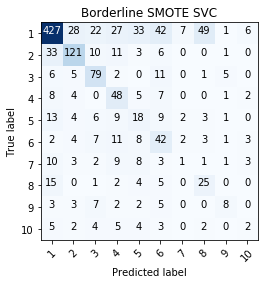

In [26]:
X_train, X_test, y_train, y_test = produce_smoted()
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

svc = SVC(kernel='rbf', gamma='auto', probability=True)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
y_pred = np.ravel(y_pred)

# Metrics
balanced_acc = balanced_accuracy_score(y_test, y_pred)
geom = geometric_mean_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

# Inspect
fig, ax = plt.subplots(ncols=1)
print('Borderline SMOTE SVC performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f} - Accuracy {:.2f}'
      .format(balanced_acc, geom, acc))

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=np.unique(y_test), ax=ax,
                      title='Borderline SMOTE SVC')
plt.show()

The above is an example with just one configuration of synthetic oversampling and one classifier, but our comprehensive testing revealed that all of the oversampled datasets performed significantly worse than the imbalanced datasets. 

This is an impetus to consider other approaches to balancing. Popular alternatives to balancing are creating an ensemble of balanced subsets of the data either by boostrap aggregation ("bagging") or by using a balanced random forest [8]. The imblearn library provides us tools for this in the form of BalancedBaggingClassifier and BalancedRandomForestClassifier.

In [27]:
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier

Testing a Balanced Random Forest

Balanced Random Forest classifier performance:
Balanced accuracy: 0.43 - Geometric mean 0.36 - Accuracy 0.47
[[338  27  12  72  36  23  14  90  15  26]
 [ 27  75  18  25   7   5   1   5  18   4]
 [  4   3  61   3   5   2   2   0  16   2]
 [  2   8   1  41   8   4   3   2   6   1]
 [ 10   5   2   5  11   7   1   8   7   8]
 [  3   1  10   8   7  26   0   5  13   5]
 [  6   1   0  10   5   1   3   8   5   3]
 [  4   0   0   5   6   1   0  39   0   4]
 [  0   1   5   0   1   2   0   0  19   0]
 [  2   0   0   6   1   0   2   7   1   7]]



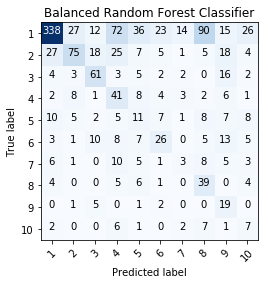

In [29]:
data = create_dataset()
X = data.drop(labels=0, axis='columns')
y = data[[0]]

# Split data set into train and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=0)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Balanced random forest
brf = BalancedRandomForestClassifier(n_estimators=200, random_state=0, n_jobs=-1)
brf.fit(X_train, y_train)

# Validate
y_pred_brf = brf.predict(X_test)
y_pred_brf = np.ravel(y_pred_brf)
# Metrics
balanced_acc = balanced_accuracy_score(y_test, y_pred_brf)
geom = geometric_mean_score(y_test, y_pred_brf)
acc = accuracy_score(y_test, y_pred_brf)

# Inspect
fig, ax = plt.subplots(ncols=1)
print('Balanced Random Forest classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f} - Accuracy {:.2f}'
      .format(balanced_acc, geom, acc))

cm_brf = confusion_matrix(y_test, y_pred_brf)
plot_confusion_matrix(cm_brf, classes=np.unique(y_test), ax=ax,
                      title='Balanced Random Forest Classifier')
plt.show()

Testing a Balanced Bagging Classifier

Balanced Bagging Classifier performance:
Balanced accuracy: 0.45 - Geometric mean 0.38 - Accuracy 0.53
[[361  62  11  40  36  33  13  71   8  18]
 [ 26 113  15   8   3   5   1   3  10   1]
 [  2  12  69   0   7   1   0   1   5   1]
 [  2   9   1  41  14   6   1   0   1   1]
 [ 12   4   2   4  18   8   3   4   4   5]
 [  2   2  11  11   6  34   0   3   4   5]
 [  5   5   3  11   4   1   3   6   2   2]
 [  9   0   0   6   7   5   0  29   0   3]
 [  0   3   6   1   2   1   0   0  15   0]
 [  4   1   0   7   3   2   1   1   1   6]]



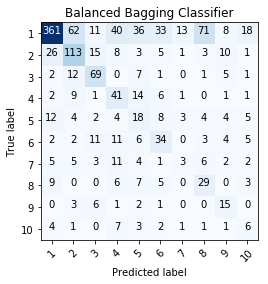

In [30]:
data = create_dataset()
X = data.drop(labels=0, axis='columns')
y = data[[0]]

# Split data set into train and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=0)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)


# Deploy a Balanced Bagger with SVC
bbc = BalancedBaggingClassifier(svc, n_estimators=100, random_state=0, n_jobs=-1)
bbc.fit(X_train, y_train)

# Validate
y_pred_bbc = bbc.predict(X_test)
y_pred_bbc = np.ravel(y_pred_bbc)

# Metrics
balanced_acc = balanced_accuracy_score(y_test, y_pred_bbc)
geom = geometric_mean_score(y_test, y_pred_bbc)
acc = accuracy_score(y_test, y_pred_bbc)

# Inspect
fig, ax = plt.subplots(ncols=1)
print('Balanced Bagging Classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f} - Accuracy {:.2f}'
      .format(balanced_acc, geom, acc))

cm_bbc = confusion_matrix(y_test, y_pred_bbc)
plot_confusion_matrix(cm_bbc, classes=np.unique(y_test), ax=ax,
                      title='Balanced Bagging Classifier')
plt.show()

Clearly, these perform even worse than synthetic oversampling and thus we've exhausted the scope of our study. 

## 4. Results

The best performing estimator was an ensembled, unbalanced XGBoosted-OneVsRest approach with validation accuracy value of approximately 0.6649. 
In comparison, the balanced estimators did considerably worse: borderlineSMOTE with SVC was 0.59, balanced bagging 
classifier was 0.53, and balanced random forest classifier performed the worst with an accuracy value of 0.47.
It is worth noting that the unensembled and unbalanced XGBoost had an accuracy of 0.65, which is marginally lower 
than the value of the ensembled and unbalanced XGBoosted-OneVsRest value. However, looking at the accuracy value
of unensembled and unbalanced SVC's accuracy value of 0.64, we notice that borderlineSMOTE with SVC performed critically 
worse with an accuracy of 0.59.

Comparing the results with Kaggle's output, the best validation accuracy value received was 0.65562, which is slightly lower
than the accuracy value of the local estimation, which is to be expected. The log-loss value obtained from Kaggle is an extremely high value of 0.20829. We consider this to be the result of training our models using accuracy metrics and ignoring logloss altogether.

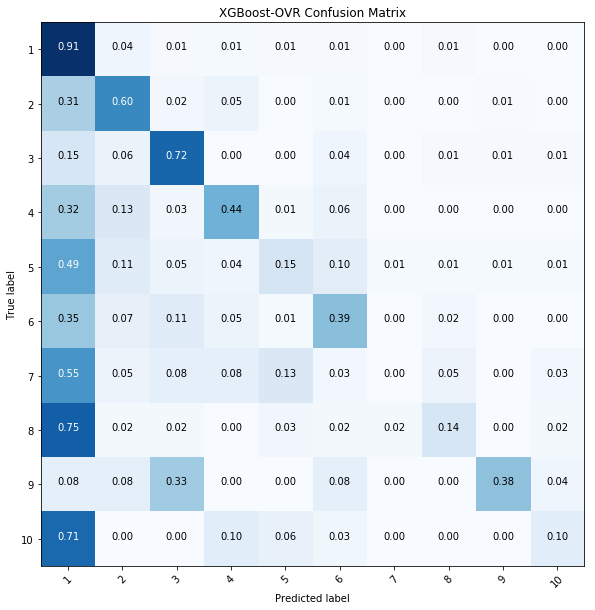

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
# Fetch cm_final from Appendix to do produce this
plot_confusion_matrix(cm_final, classes=np.unique(y_test), ax=ax, normalize=True,
                      title='XGBoost-OVR Confusion Matrix')
plt.show()

## 5. Discussion/Conclusions

Looking at the results, it can be said that the increase due to ensembling our classifiers was at most marginal. Ensembling XGB
resulted in a small increase of accuracy of 0.011. Other ensembles produced lower accuracy values than the XGB-OVR.
These results were surprising and in contradiction with expectations based on the literature review (check introduction).
According to Chen & Guestrin (2016) it is no surprise that the ensemble methods did not perform better than the XGB and XGB-OVR,
since XGB itself is a state-of-art method for machine learning problems. XGB has been used in multiple Kaggle competitions as
the winning method, for example in 2015 out of 29 winning solutions, 17 used XGB. It has also been commented by the winners
that ensembled XGB methods only produced minimal improvement compared to a well-configured XGB. Moreover, XGB is also
scalable, so it can be used for a variety of machine learning problems. [6] Since XGB is considered to be a state-of-art method,
it is necessary to question if the data processing has been done in an ideal manner, since the accuracy and log-loss values
have not been as high as they could have been, at least according to performance expectations of the XGB. Also, it is only natural
that our other methods would not reach as high of an accuracy as the XGB did.

Other classifiers that performed well were the SVC, the LogReg, the neural networks and the Random Forest. According to Chen et al. (2016) neural networks together with XGB are
known to produce excellent results and have often claimed winning positions in machine  learning competitions. [6] However, in their paper, Zhou & Liu (2006) argue that
in training cost-sensitive neural networks different ensembling methods, over- and undersampling have been most useful on two-class tasks,
rather than multi-class problems. In contrast, multi-class problems can cause the aforementioned methods to be counter-productive,
i.e. they would produce results worse than without using these methods, this trend is also applicable to our results, which have been discussed
above. However, Zhou & Liu (2006) suggest that multi-class problems can be converted into a set of binary classification tasks, which can be
a daunting task if there are a wide variety of classes. However, by converting the problem to a series of binary classification tasks,
it is possible to use methods that are known to work in an excellent manner for two-class problems, but poorly in multi-class
tasks. [7]

Looking at the accuracy values for balanced classifiers, it is worth noting that the balanced values are actually lower than
unbalanced. For example, unbalanced SVC gave an accuracy of 0.64, whereas borderline SMOTE SVC had an accuracy of 0.59, which
is a considerably 0.05 lower than the unbalanced SVC. However, how is it possible that balancing the dataset could lead to
less accurate results? We propose that the large majority class allows the classifiers to gain edge in terms of bias. If the majority class is significantly larger than other classes (as is the case here), the classifiers can "cheat" their way to a higher accuracy by tending towards the majority class at every prediction. This is reflected in the confusiom matrix of our final model and would also explain why the logloss score is so unreasonably high: the classifier is over-confident while misclassifying minority classes into the majority class. We tested this hypothesis by trying to classify the dataset without the majority class and indeed found that the accuracy remains under 60%. This implies that the improvement gained in the classification of the entire dataset is partly due to the edge from bias. You can find a single no-majority test run in the appendix.

The methods used for balancing were synthetic oversampling the minor classes (since undersampling the major class would lead to a prohibitively small dataset, due to the class distribution) and balanced ensembles. Since these did not improve our accuracy at all, we suggest that the potential improvement in classification lies in data preprocessing and more mindful feature selection.

## 6. References

[1] Dietterich, T. G., Ensemble Methods in Machine Learning. 2012.  URL: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.34.4718&rep=rep1&type=pdf

[2] Zhou, Z.-H. (2012). Ensemble Methods Foundations and Algorithms. Boca Raton, Florida: CRC Press, Taylor & Francis
    Group. URL: http://www2.islab.ntua.gr/attachments/article/86/Ensemble%20methods%20-%20Zhou.pdf
            
[3] Fernández, A., López, V., Galar, M., José del Jesus, M., Herrera, F., Analysing the classification of imbalanced
    data-sets with multiple classes: Binarization techniques and ad-hoc approaches. Knowledge-Based Systems (42), 2013.
    pp. 97-110. 
    URL: citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.648.966&rep=rep1&type=pdf
        
[4] Chawla, N. V., Bowyer, K. W., Hall, L. O., Kegelmeyer, W. P., SMOTE: Synthetic Minority Over-sampling Technique.
    Journal of Artificial Intelligence Research (16), 2002.
    URL: https://www.jair.org/index.php/jair/article/view/10302
    
[5] He, H., Bai, Y., Garcia, E. A., Li, S., ADASYN: Adaptive Synthetic Sampling Approach for Imbalanced Learning,
    IEEE International joint Conference on Neural Networks, 2008.
    URL: https://sci2s.ugr.es/keel/pdf/algorithm/congreso/2008-He-ieee.pdf
            
[6] Chen, T., Guestrin, C., XGBoost: A Scalable Tree Boosting System, ACM, 2016. DOI: http://dx.doi.org/10.1145/2939672.2939785
    URL: http://delivery.acm.org/10.1145/2940000/2939785/p785-chen.pdf?ip=195.148.16.9&id=2939785&acc=CHORUS&key=4D4702B0C3E38B35%2E4D4702B0C3E38B35%2E4D4702B0C3E38B35%2E6D218144511F3437&__acm__=1541065815_383336808d06becf8ab3e00069cdae78
            
[7] Zhou, Z.-H., Liu, X.-Y., Training Cost-Sensitive Neural Networks with Methods Addressing the Class Imbalance Problem,
    IEEE Transactions of Knowledge and Data Engineering, 2006.
    URL: https://sci2s.ugr.es/keel/pdf/algorithm/articulo/2006%20-%20IEEE_TKDE%20-%20Zhou_Liu.pdf

[8] Chao, C., Liaw, A., Breiman, L., Using Random Forest to Learn Imbalanced Data. URL: https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf
    
    

## Appendix

This is our final model (for producing the confusion matrix in Results):

In [6]:
# Final model
import warnings
warnings.filterwarnings('ignore')

ovr = joblib.load('./models/best_ovr.joblib')

# Load data
data = create_dataset()

# Split dataset into train and test
train, test = train_test_split(data, test_size=0.3, random_state=0)

x_train = train.drop(labels=0, axis='columns')
y_train = np.ravel(train[[0]])

x_test = test.drop(labels=0, axis='columns')
y_test = np.ravel(test[[0]])

y_pred = ovr.predict(x_test)
cm_final = confusion_matrix(y_test, y_pred)

This is an example of classification without the majority class:

No Majority OVR classifier performance:
Balanced accuracy: 0.45 - Geometric mean 0.00 - Accuracy 0.58


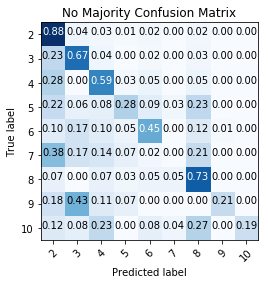

In [5]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.externals import joblib
from confusionvisuals import plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from imblearn.metrics import geometric_mean_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier

# Testing classification without majority class

# Read datasets
df_data = pd.read_csv('train_data.csv', header=None)
df_labels = pd.read_csv('train_labels.csv', header=None)
data = pd.concat([df_labels, df_data], axis='columns', ignore_index=True)

# Drop majority class
no_majority = data[(data[[0]] != 1).all(axis=1)].sample(frac=1).reset_index(drop=True)
y = no_majority[[0]]

# Clean and scale data as usual
# Rhythm
rhythm = no_majority.iloc[:, 1:169].copy()

# Chroma
chroma_cleaned = no_majority.iloc[:, 169:193].copy()

# MFCCs
mfcc_cleaned = no_majority.iloc[:, 221:265].copy()

cleaned_x = pd.concat([rhythm, chroma_cleaned, mfcc_cleaned],
                      axis='columns',
                      ignore_index=True)

# Outlier detection
threshold = 3
for col in range(cleaned_x.shape[1]):
    mean = np.mean(cleaned_x.iloc[:, col])
    z = np.abs(stats.zscore(cleaned_x.iloc[:, col]))
    rows = np.where(z > threshold)
    for row in rows:
        cleaned_x.at[row, col] = mean
        
# Scaling
scaler = PowerTransformer()
scaled_data = scaler.fit_transform(cleaned_x)
scaled_df = pd.DataFrame(scaled_data)

# Divide into training and validation
X_train, X_test, y_train, y_test = train_test_split(scaled_df, y, test_size=0.3, stratify=y)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Test some SVC classifiers
kernel_params = ['linear', 'poly', 'rbf', 'sigmoid']
degrees = [3, 4, 5]

current_best_score = 0
current_best_svc = None
for kernel in kernel_params:
    for degree in degrees:
        clf = SVC(kernel=kernel, gamma='auto', probability=True, degree=degree)
        svc_fit = clf.fit(X_train, y_train)
        svc_score = svc_fit.score(X_test, y_test)
        if svc_score > current_best_score:
            current_best_score = svc_score
            current_best_svc = svc_fit
            
# Validate and show confusion matrix
y_pred_svc = current_best_svc.predict(X_test)

svc = current_best_svc

# Run OVR
ovr = OneVsRestClassifier(svc, n_jobs=-1)
ovr.fit(X_train, y_train)
 
# Validate and show confusion matrix
y_pred_ovr = ovr.predict(X_test)

# Metrics
balanced_acc = balanced_accuracy_score(y_test, y_pred_ovr)
geom = geometric_mean_score(y_test, y_pred_ovr)
acc = accuracy_score(y_test, y_pred_ovr)

# Inspect
fig, ax = plt.subplots(ncols=1)
print('No Majority OVR classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f} - Accuracy {:.2f}'
      .format(balanced_acc, geom, acc))

cm = confusion_matrix(y_test, y_pred_ovr)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
classes = np.unique(y_test)

ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title('No Majority Confusion Matrix')
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.sca(ax)
plt.yticks(tick_marks, classes)

fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

plt.show()